### Load basic libraries

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('darkgrid')
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

### Load sklearn commands

In [135]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

### Load data

* survival - Survival (0 = No; 1 = Yes)
* class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
* name - Name
* title - Title
* sex - Sex
* age - Age
* sibsp - Number of Siblings/Spouses Aboard
* parch - Number of Parents/Children Aboard
* ticket - Ticket Number
* fare - Passenger Fare
* cabin - Cabin
* embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [136]:
pd_titanic = pd.read_csv('./data/titanic-2.csv')
pd_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [137]:
pd_titanic.shape

(891, 13)

## Data Exploring and Cleansing

In [138]:
""" Localizamos duplicados """

sum(pd_titanic.duplicated())

0

In [139]:
""" Localizamos valores nulos """

pd_titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

In [140]:
""" Tomamos una decisión con los valores nulos """

# Age -> Los cambiamos por el valor de la mediana de edad
med = np.nanmedian(pd_titanic['Age'])
pd_titanic['Age2'] = pd_titanic['Age'].fillna(med)

# Cabin -> Creamos una variable dummy para distinguir valores nulos de no nulos
pd_titanic['Cabin'] = pd_titanic['Cabin'].fillna(0)
pd_titanic['hasCabin']=pd_titanic['Cabin'].apply(lambda x: 0 if x==0 else 1)

# Embarked -> Al ser solo dos, los eliminamos
print(pd_titanic.shape)
pd_titanic = pd_titanic[~pd_titanic.Embarked.isnull()]
print(pd_titanic.shape)

(891, 15)
(889, 15)


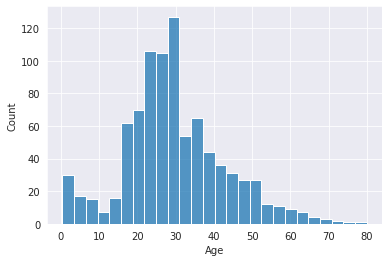

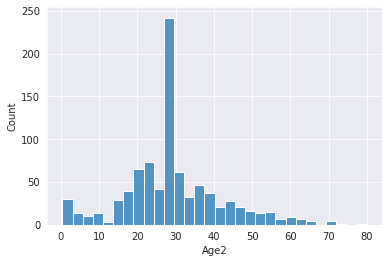

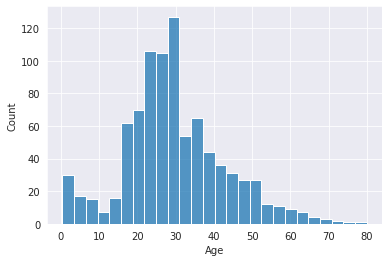

In [141]:
""" Imputers para rellenar valores nulos """

from sklearn.impute import SimpleImputer, KNNImputer

imputer1 = SimpleImputer(strategy = 'mean')
imputer2 = SimpleImputer(strategy = 'median')
imputer3 = SimpleImputer(strategy = 'most_frequent')
imputer4 = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# Vamos a imputar con el algoritmo KNN, buscando los valores más parecidos a las columnas que deseemos
key_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
imputer4.fit(pd_titanic[key_cols])
pd_titanic[key_cols] = imputer4.transform(pd_titanic[key_cols])

""" Vamos a contrastar cómo quedarían los histogramas de Age en los siguientes casos: """

# 1) Histograma con valores nulos (los ignora básicamente)
sns.histplot(pd_titanic.Age)
plt.show()

# 2) Histograma con los valores de Age rellenados con el valor de la mediana
sns.histplot(pd_titanic.Age2)
plt.show()

# 3) Histograma con los valores de Age rellenados con el valor del imputer KNN
sns.histplot(pd_titanic.Age)
plt.show()

In [142]:
""" Realizamos una exploración breve EDA para variables categóricas, numéricas y target """

target   = 'Survived'
cat_cols = ['Pclass','Sex','SibSp','Parch','Embarked','Title','hasCabin']
num_cols = ['Age','Fare']

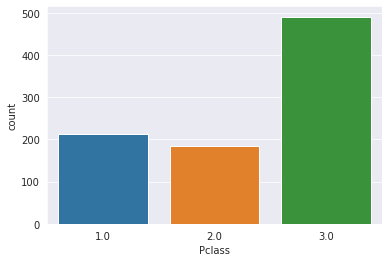

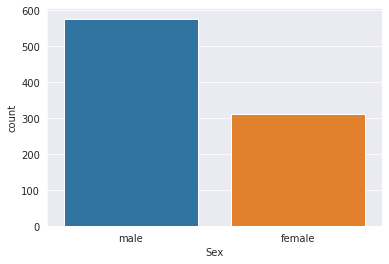

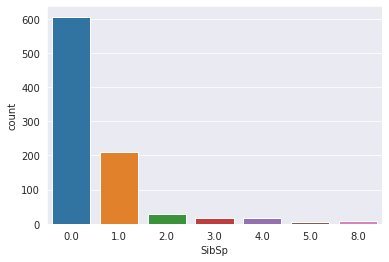

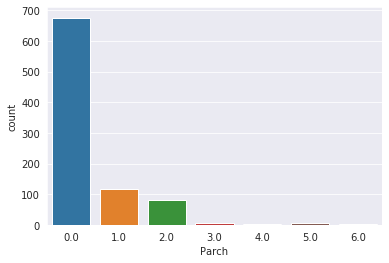

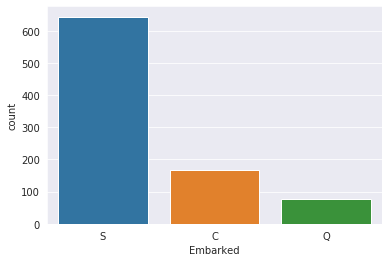

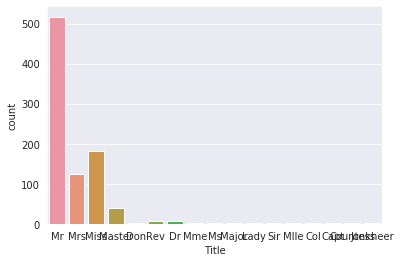

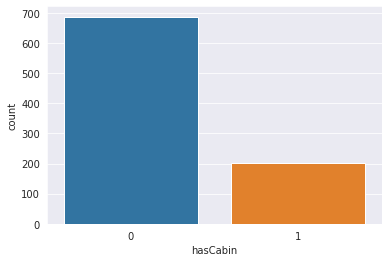

In [143]:
for col in cat_cols:
    sns.countplot(pd_titanic[col])
    plt.show()

In [144]:
""" Aquellas categorías con pocos datos, las juntamos """

pd_titanic['SibSp'] = pd_titanic.SibSp.apply(lambda x: 2 if x>=2 else x)
pd_titanic['Parch'] = pd_titanic.Parch.apply(lambda x: 2 if x>=2 else x)
pd_titanic['Title'] = pd_titanic.Title.apply(lambda x: x if x in ['Mr', 'Mrs', 'Miss'] else 'Other')


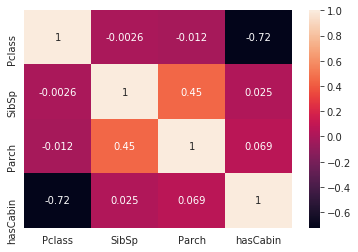

In [145]:
sns.heatmap(pd_titanic[cat_cols].corr(), annot=True)
plt.show()

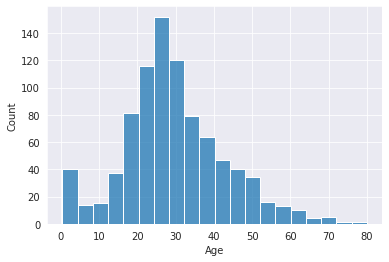

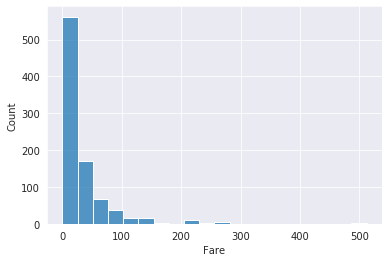

In [146]:
for col in num_cols:
    sns.histplot(pd_titanic[col], bins=20)
    plt.show()

In [147]:
""" Técnicas para la detección de Outliers en variables numéricas """

# seis sigma 

for col in num_cols:
    print(' *** ')
    mu = np.mean(pd_titanic[col])
    sigma = np.std(pd_titanic[col])
    values = pd_titanic[col]
    outliers = ( values < ( mu - 3 * sigma ) ) | ( values > ( mu + 3 * sigma ) )
    print(values[outliers])
    

 *** 
96     71.0
116    70.5
493    71.0
630    80.0
672    70.0
745    70.0
851    74.0
Name: Age, dtype: float64
 *** 
27     263.0000
88     263.0000
118    247.5208
258    512.3292
299    247.5208
311    262.3750
341    263.0000
377    211.5000
380    227.5250
438    263.0000
527    221.7792
557    227.5250
679    512.3292
689    211.3375
700    227.5250
716    227.5250
730    211.3375
737    512.3292
742    262.3750
779    211.3375
Name: Fare, dtype: float64


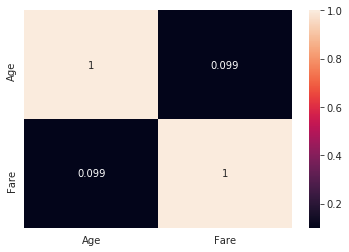

In [148]:
sns.heatmap(pd_titanic[num_cols].corr(), annot=True)
plt.show()

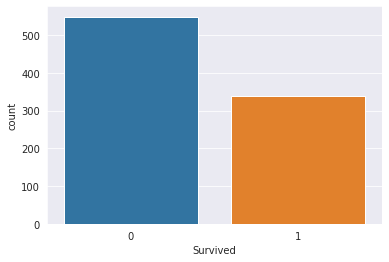

In [149]:
""" Estudio la variable target """

sns.countplot(pd_titanic.Survived)
plt.show()

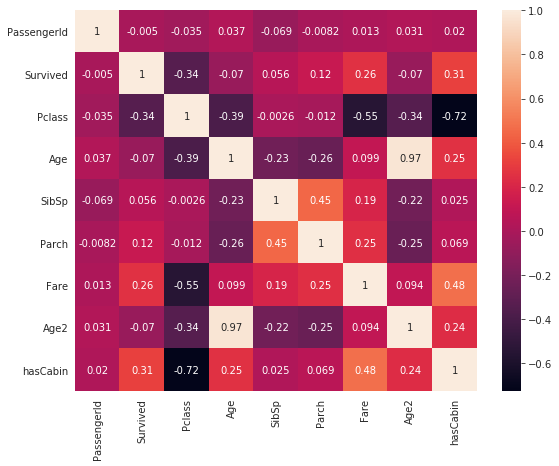

In [150]:
plt.figure(figsize=(9,7))
sns.heatmap(pd_titanic.corr(), annot=True)
plt.show()

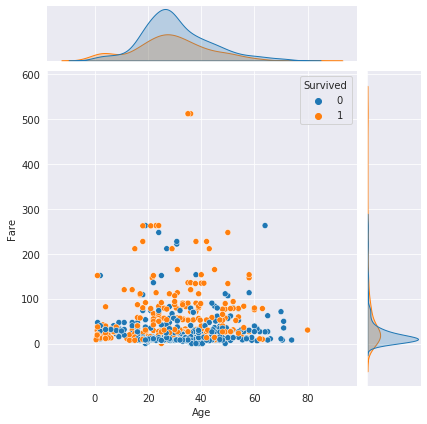

In [151]:
sns.jointplot(x='Age', y='Fare', hue='Survived', data=pd_titanic, kind='scatter')
plt.show()

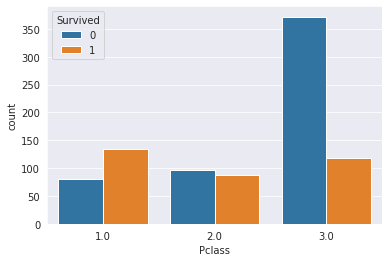

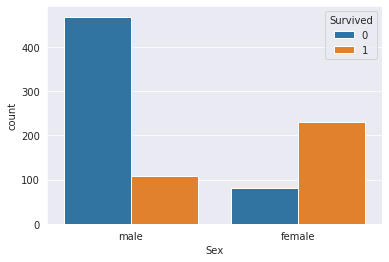

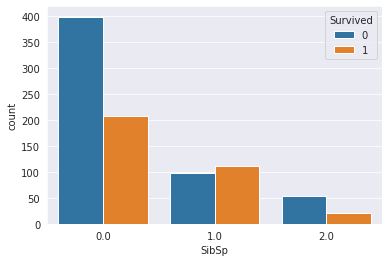

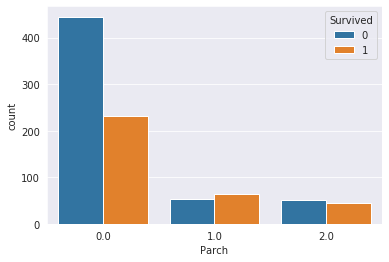

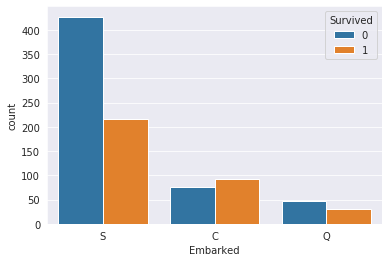

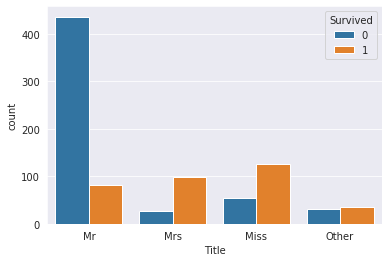

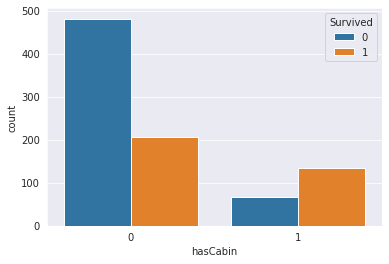

In [152]:
for col in cat_cols:
    sns.countplot(pd_titanic[col], hue=pd_titanic.Survived)
    plt.show()

## Categorical data transformation

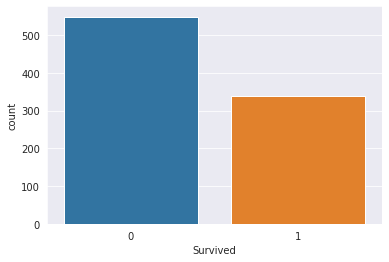

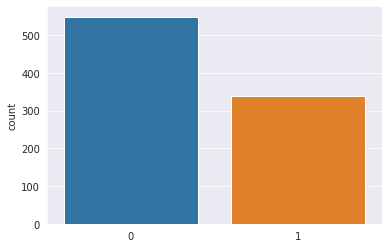

0    0
1    1
2    1
3    1
4    0
5    0
6    0
7    0
8    1
9    1
Name: Survived, dtype: int64
[0 1 1 1 0 0 0 0 1 1]
[0 1 1 1 0 0 0 0 1 1]


In [153]:
""" Target variable """

from sklearn.preprocessing import LabelEncoder

y = pd_titanic['Survived']

le = LabelEncoder()
le.fit(y)
y_encoded = le.transform(y)

sns.countplot(y)
plt.show()

sns.countplot(y_encoded)
plt.show()

y_unencoded = le.inverse_transform(y_encoded)
print(y[0:10])
print(y_encoded[0:10])
print(y_unencoded[0:10])

# Transformación de variables

In [154]:
cat_cols = ['Pclass','Sex','SibSp','Parch','Embarked','Title','hasCabin']
num_cols = ['Age','Fare']

target   = 'Survived'
features = cat_cols + num_cols

Esta parte la haremos con __Pandas__ (dummies)

In [155]:
""" Categorical Features """

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

pd_titanic2 = pd_titanic.copy()
pd_titanic2 = pd_titanic[features]

# Dummies
cat_cols1 = ['Sex', 'Embarked', 'Pclass']
pd_titanic2 = pd.get_dummies(pd_titanic2, columns=cat_cols1, drop_first=True)
cat_cols2 = ['SibSp', 'Title', 'Parch']
pd_titanic2 = pd.get_dummies(pd_titanic2, columns=cat_cols2) # muy desbalanceados

pd_titanic2.sum()
cat_cols3 = pd_titanic2.sum()
cat_cols3 = cat_cols3[cat_cols3 > 20]
pd_titanic2 = pd_titanic2[cat_cols3.index]
pd_titanic2.head()

,hasCabin,Age,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2.0,Pclass_3.0,SibSp_0.0,SibSp_1.0,SibSp_2.0,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Parch_0.0,Parch_1.0,Parch_2.0
0,0,22.0,7.2500,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0
1,1,38.0,71.2833,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
2,0,26.0,7.9250,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0
3,1,35.0,53.1000,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0
4,0,35.0,8.0500,1,0,1,0,1,1,0,0,0,1,0,0,1,0,0


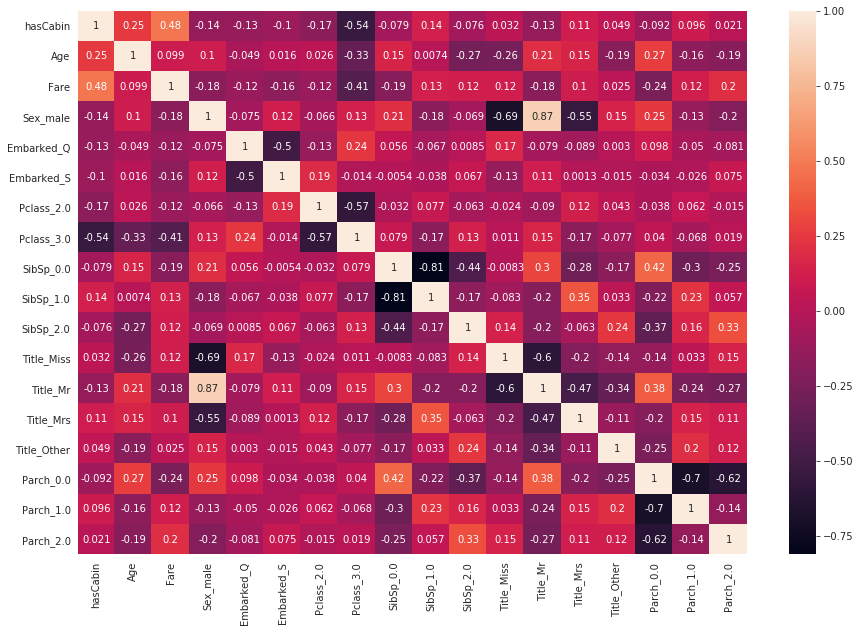

In [156]:
plt.figure(figsize=(15,10))
sns.heatmap(pd_titanic2.corr(), annot=True)
plt.show()

LR: 0.820084 (0.033851)
LDA: 0.820072 (0.040656)
KNN: 0.705248 (0.053832)
DTC: 0.773991 (0.043345)
NB: 0.781831 (0.034981)
RFC: 0.817799 (0.019109)
SVM: 0.670480 (0.044560)


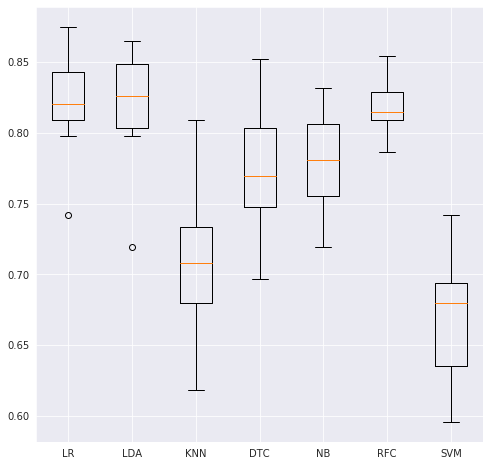

In [157]:
""" Probamos un primer modelo con estas variables """

y = pd_titanic.Survived
X = pd_titanic2

def boxplots_algorithms(results, names):
    
    plt.figure(figsize=(8,8))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.show()
    
def model_evaluation(models, X, y):
    results = []
    names = []
    scoring = 'accuracy'
    for name, model in models:
        kfold = KFold(n_splits=10, shuffle=True, random_state=7)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    
    return results, names

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFC', RandomForestClassifier()))
models.append(('SVM', SVC()))

results, names = model_evaluation(models, X, y)    
boxplots_algorithms(results, names)

In [158]:
""" Probamos a ver los resultados de clasificacion del mejor modelo (supuesto) """

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

model = LogisticRegression()
model = model.fit(X_train,y_train)

y_pred = model.predict(X_test)
confusion_matrix(y_pred, y_test)

array([[90, 22],
       [12, 54]])

Esta parte la haremos con transformers de __sklearn__

In [159]:
""" Utilizaremos transformers de tipo OnehotEncoder de varios tipos para cada variable categórica """

pd_titanic3 = pd_titanic.copy()
pd_titanic3 = pd_titanic3[cat_cols + num_cols + ['Survived']]

# Tipo 1
enc_Sex = OneHotEncoder(drop='if_binary')
X = pd_titanic3[['Sex']]
Xenc = enc_Sex.fit_transform(X)
# Xenc.toarray()
# enc_Sex.inverse_transform(Xenc)

# Tipo 2
enc_Embarked = OneHotEncoder(drop='first')
X = pd_titanic3[['Embarked']]
Xenc = enc_Embarked.fit_transform(X)
# enc_Embarked.get_feature_names()
 
# Tipo 3
enc_Title = OneHotEncoder(drop='first')
X = pd_titanic3[['Title']]
Xenc = enc_Title.fit_transform(X)
# enc_Title.get_feature_names()

# Tipo 4
titles = [['Miss', 'Mr', 'Mrs']]
enc_Title = OneHotEncoder(categories=titles, handle_unknown='ignore')
X = pd_titanic3[['Title']]
Xenc = enc_Title.fit_transform(X)
# enc_Title.get_feature_names()

siblings = [['0.0', '1.0', '2.0']]
enc_Sibs = OneHotEncoder(categories=siblings, handle_unknown='ignore')
X = pd_titanic3[['SibSp']]
Xenc = enc_Sibs.fit_transform(X)
# enc_Title.get_feature_names()

In [160]:
""" Ahora wrappearemos todas y cada una de ellas en un transformador de ColumnTransformer """

ctransformer = ColumnTransformer([
    ("imputer", KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean'), 
     ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
    ("encoder_tipo1", OneHotEncoder(drop='if_binary'), ['Sex']),
    ("encoder_tipo2", OneHotEncoder(drop='first'), ['Embarked', 'Pclass']),
    ("encoder_tipo3", OneHotEncoder(), ['SibSp', 'Title', 'Parch']),
    ("encoder_tipo4", OneHotEncoder(categories=siblings, handle_unknown='ignore'), ['SibSp']),
    ("encoder_tipo5", OneHotEncoder(categories=titles, handle_unknown='ignore'), ['Title'])
])

# Vemos en una prueba cómo funciona y cómo nos quedaría el dataset
ctransformed = ctransformer.fit_transform(pd_titanic3)

In [161]:
""" Probamos un primer modelo con estas variables """

X = pd_titanic3[features]
y = pd_titanic3['Survived']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=99)

algorithm = LogisticRegression()
pipeline = make_pipeline(ctransformer, algorithm)

pipeline = pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print(accuracy_score(y_pred, y_test))

confusion_matrix(y_pred, y_test)

0.7808988764044944


array([[86, 23],
       [16, 53]])

In [162]:
""" Ahora igual, pero con Validación cruzada """

kfold = KFold(n_splits=10, shuffle=True, random_state=7)
cv_results = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy')
msg = "%f (%f)" % (cv_results.mean(), cv_results.std())
print(msg)

y_pred = cross_val_predict(pipeline, X, y, cv=kfold)
print(accuracy_score(y_pred, y))
confusion_matrix(y_pred, y)

0.816701 (0.037086)
0.8166479190101237


array([[478,  92],
       [ 71, 248]])

### Box-Cox

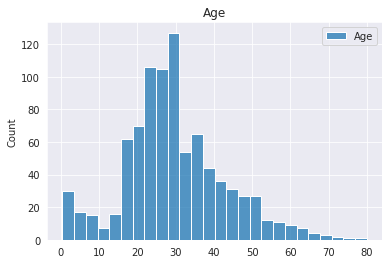

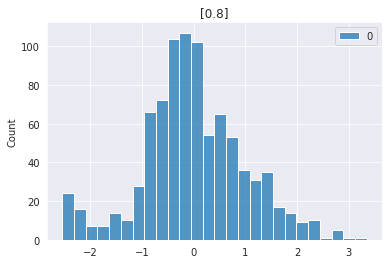

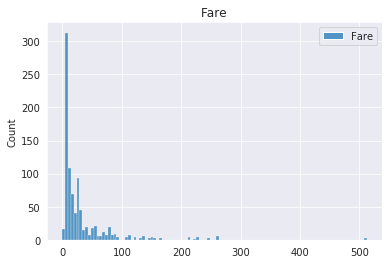

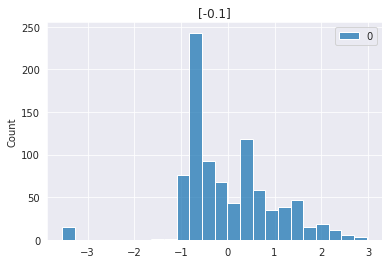

In [163]:
""" A las variables numéricas aplicaremos una transformación para Normalizar los datos (en medida de lo posible) """

from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='box-cox')
# pt = PowerTransformer(method='box-cox', standardize=True)

for feature in num_cols:
    X = pd_titanic3[[feature]]
    Xtrans = pt.fit_transform(X+1)

    plt.title(feature)
    sns.histplot(X)
    plt.show()
    
    plt.title(pt.lambdas_)
    sns.histplot(Xtrans)
    plt.show()

In [164]:
""" Incluiremos esta transformación dentro del Column Transformer """

pd_titanic3.Fare = pd_titanic2.Fare +1 # Le sumamos 1 solamente para que Fare no tome valor 0, fallaría Box-Cox

ctransformer = ColumnTransformer([
    ("imputer", KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean'), 
     ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
    ("box-cox", PowerTransformer(method='box-cox'), ['Age', 'Fare']),
    ("encoder_tipo1", OneHotEncoder(drop='if_binary'), ['Sex']),
    ("encoder_tipo2", OneHotEncoder(drop='first'), ['Embarked', 'Pclass']),
    ("encoder_tipo3", OneHotEncoder(), ['SibSp', 'Title', 'Parch']),
    ("encoder_tipo4", OneHotEncoder(categories=siblings, handle_unknown='ignore'), ['SibSp']),
    ("encoder_tipo5", OneHotEncoder(categories=titles, handle_unknown='ignore'), ['Title'])
])
ctransformed = ctransformer.fit_transform(pd_titanic3)

In [165]:
""" Hacemos una prueba de algortimo """

X = pd_titanic3[features]
y = pd_titanic3['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

algorithm = LogisticRegression()
pipeline = make_pipeline(ctransformer, algorithm)

pipeline = pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print(accuracy_score(y_pred, y_test))

confusion_matrix(y_pred, y_test)

0.7696629213483146


array([[84, 23],
       [18, 53]])

In [166]:
""" Y ahora con Validación Cruzada """

kfold = KFold(n_splits=10, shuffle=True, random_state=7)
cv_results = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy')
msg = "%f (%f)" % (cv_results.mean(), cv_results.std())
print(msg)

y_pred = cross_val_predict(pipeline, X, y, cv=kfold)
print(accuracy_score(y_pred, y))
confusion_matrix(y_pred, y)

0.820084 (0.036713)
0.8200224971878515


array([[477,  88],
       [ 72, 252]])